In [9]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
from skimage import measure, morphology
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.spatial import ConvexHull
import pandas as pd

In [10]:
# Paths
image_dir = "images_and_labels/"
label_dir = "images_and_labels/"

image_files = sorted(glob(os.path.join(image_dir, "*.tiff")))
label_files = sorted(glob(os.path.join(label_dir, "*.txt")))

def load_labels(txt_file):
    df = pd.read_csv(txt_file)
    # Assuming columns: x, y, label
    return df

In [11]:
os.getcwd()

'C:\\Users\\indhi\\ML_Corneal_Endothellium_Imaging'

In [12]:
print(image_dir)

images_and_labels/


In [13]:
len(image_files)

385

In [14]:
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.equalizeHist(img)   # histogram equalization
    img = img / 255.0             # normalize
    return img

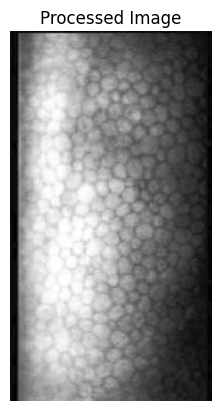

In [15]:
import matplotlib.pyplot as plt
import cv2

# Preprocess the image
img_path = "images_and_labels/71866.tiff"  # replace with your image path
img_processed = preprocess_image(img_path)

# Display the image
plt.imshow(img_processed, cmap='gray')
plt.title("Processed Image")
plt.axis('off')
plt.show()

In [16]:
import os
print(os.path.exists("images/71866.tiff"))

False


In [17]:
# ---------------- PARAMETERS ----------------
IMG_SIZE = 256 # resizing for unet
PIXEL_TO_MM2 = 0.0001  # adjust for your image calibration
CELL_MIN_SIZE = 50     # min pixels to count as a cell

In [18]:
# ---------------- FUNCTIONS ----------------

# Preprocessing
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Cannot read image: {img_path}")
    img = cv2.equalizeHist(img)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img[..., np.newaxis]  # add channel for U-Net



Original size: 260 x 477 pixels
Processed size: 256 x 256 pixels


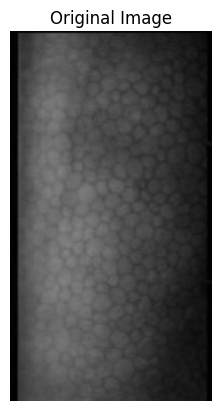

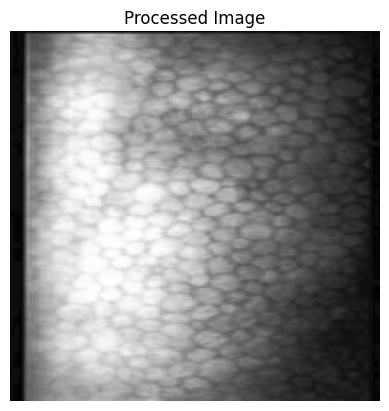

In [19]:
### Visualzing the preprocessing and resizing


import matplotlib.pyplot as plt
import cv2

# Preprocess the image
img_path = "images_and_labels/71866.tiff"  # replace with your image path
img_processed = preprocess_image(img_path)

orig_img = cv2.imread(img_path)
height, width = orig_img.shape[:2]  # shape = (height, width, channels)
print(f"Original size: {width} x {height} pixels")

height, width = img_processed.shape[:2]  # shape = (height, width, channels)
print(f"Processed size: {width} x {height} pixels")

# Display the image
plt.imshow(orig_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

plt.imshow(img_processed, cmap='gray')
plt.title("Processed Image")
plt.axis('off')
plt.show()

In [20]:
# mask creation function from coordinates:

import numpy as np
import cv2
import pandas as pd

IMG_SIZE = 256
def create_mask_from_txt(txt_file, img_original_shape):
    df = pd.read_csv(txt_file, sep="\t")

    h, w = img_original_shape
    mask = np.zeros((h, w), dtype=np.uint8)

    for _, row in df.iterrows():
        x = int(row["x"])
        y = int(row["y"])
        cv2.circle(mask, (x, y), radius=3, color=1, thickness=-1)

    return mask
# resize mask
def preprocess_mask(mask):
    mask_resized = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    return mask_resized[..., np.newaxis]     # add channel dimension

# --- Check size and values ---
print("Original mask shape:", mask.shape)
print("Resized mask shape:", mask_resized.shape)
print("Unique values in resized mask:", np.unique(mask_resized))

NameError: name 'mask' is not defined

In [ ]:
### visualizing the created mask

import matplotlib.pyplot as plt
import cv2
import os

# Example paths
img_path = "images_and_labels/71866.tiff"
txt_path = "images_and_labels/71866.txt"

# Load original image
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    raise FileNotFoundError("Image not found")

h, w = img.shape
print("Image shape:", img.shape)
mask_img = create_mask_from_txt(txt_path, (h, w))
mask_resized = preprocess_mask(mask_img)



print("Mask shape:", mask_img.shape)
plt.figure(figsize=(12,4))

plt.subplot(1,6,1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,6,2)
plt.imshow(mask_img, cmap="gray")
plt.title("Generated Mask")
plt.axis("off")

plt.subplot(1,6,3)
plt.imshow(img, cmap="gray")
plt.imshow(mask_img, cmap="jet", alpha=0.4)
plt.title("Overlay")
plt.axis("off")

plt.subplot(1,6,4)
plt.imshow(img_processed, cmap="gray")
plt.title("image_processed")
plt.axis("off")

plt.subplot(1,6,5)
plt.imshow(mask_resized[...,0], cmap="gray")
plt.title("Resized Mask")
plt.axis("off")

plt.subplot(1,6,6)
plt.imshow(img, cmap="gray")
plt.imshow(mask_resized[...,0], cmap="jet", alpha=0.4)
plt.title("Overlay")
plt.axis("off")

plt.show()



In [27]:
# Build a simple U-Net model
def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = layers.Input(input_shape)
    
    # Encoder
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)
    
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)
    
    # Bottleneck
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c3)
    
    # Decoder
    u1 = layers.UpSampling2D((2,2))(c3)
    concat1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(concat1)
    c4 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c4)
    
    u2 = layers.UpSampling2D((2,2))(c4)
    concat2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(concat2)
    c5 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c5)
    
    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c5)
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [28]:
### Loading img and mask for u-net training


def load_dataset(image_dir, txt_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".tiff")])
    txt_files   = sorted([f for f in os.listdir(txt_dir) if f.endswith(".txt")])
    
    X = []
    Y = []
    
    for img_file, txt_file in zip(image_files, txt_files):
        img_path = os.path.join(image_dir, img_file)
        txt_path = os.path.join(txt_dir, txt_file)
        
        # Load image
        img = preprocess_image(img_path)
        
        # Load mask
        orig_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = create_mask_from_txt(txt_path, orig_img.shape)
        mask = preprocess_mask(mask)
        
        X.append(img)
        Y.append(mask)
    
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

In [29]:

# Example

image_dir = "images_and_labels/"
txt_dir   = "images_and_labels/"

X, Y = load_dataset(image_dir, txt_dir)

print("X shape:", X.shape)  # e.g., (num_images, 256, 256, 1)
print("Y shape:", Y.shape)  # e.g., (num_images, 256, 256, 1)
print("Unique values in mask:", np.unique(Y))

X shape: (385, 256, 256, 1)
Y shape: (385, 256, 256, 1)
Unique values in mask: [0. 1.]


In [30]:
## Unet training
## step1: splitting the data

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape)
print(Y_train.shape, Y_val.shape)

(308, 256, 256, 1) (77, 256, 256, 1)
(308, 256, 256, 1) (77, 256, 256, 1)


In [31]:
## step 2: Building the u-net model
from tensorflow.keras import layers, models

model = build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 16)      │             160 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 16)      │           2,320 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 16)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 32)      │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 64)        │          36,928 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 128, 128, 64)      │               0 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 128, 128, 96)      │               0 │ up_sampling2d[0][0],       │
│                               │                           │                 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 128, 128, 32)      │          27,680 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_1               │ (None, 256, 256, 32)      │               0 │ conv2d_7[0][0]             │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 256, 256, 48)      │               0 │ up_sampling2d_1[0][0],     │
│                               │                           │                 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 117,985 (460.88 KB)

 Trainable params: 117,985 (460.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## train the model

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=8,
    epochs=20
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


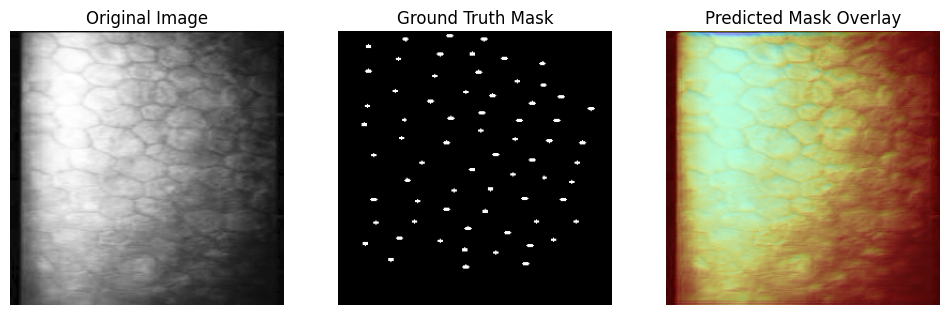

In [53]:
## Visualize the predictions

import matplotlib.pyplot as plt

idx = 31 # example image
pred_mask = model.predict(X_val[idx:idx+1])[0,...,0]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(X_val[idx,...,0], cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(Y_val[idx,...,0], cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(X_val[idx,...,0], cmap='gray') # original image
plt.imshow(pred_mask, cmap='jet', alpha=0.4)# predicted mask overlay
plt.title("Predicted Mask Overlay")
plt.axis("off")
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


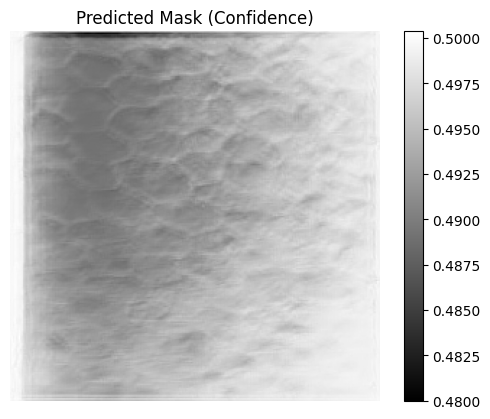

In [58]:
pred_mask_raw = model.predict(X_val[idx:idx+1])[0, :, :, 0]  # values between 0 and 1

plt.imshow(pred_mask_raw, cmap='gray')
plt.colorbar()
plt.title("Predicted Mask (Confidence)")
plt.axis('off')
plt.show()

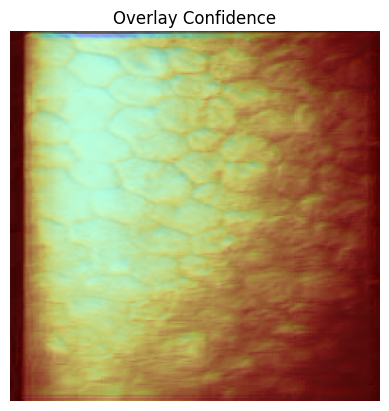

In [60]:
# Assuming pred_mask_raw has shape (256, 256)
plt.imshow(X_val[idx, :, :, 0], cmap='gray')       # original image
plt.imshow(pred_mask_raw, cmap='jet', alpha=0.4)   # overlay predicted mask confidence
plt.title("Overlay Confidence")
plt.axis('off')
plt.show()

In [20]:
# Segment cells using U-Net
def segment_with_unet(model, img):
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0, ..., 0]
    # Convert probability map to binary mask
    mask = (pred_mask > 0.5).astype(np.uint8)
    
    # Morphological cleaning
    mask = morphology.remove_small_objects(mask.astype(bool), min_size=CELL_MIN_SIZE)
    mask = morphology.remove_small_holes(mask, area_threshold=CELL_MIN_SIZE)
    
    # Label cells
    labeled_mask = measure.label(mask)
    return labeled_mask


In [21]:
# Feature extraction
def extract_features(labeled_mask):
    props = measure.regionprops(labeled_mask)
    areas = [p.area for p in props if p.area > 0]
    
    # Density
    density = len(areas) / PIXEL_TO_MM2
    
    # Coefficient of Variation
    cv = np.std(areas)/np.mean(areas) if len(areas) > 0 else 0
    
    # Hexagonality
    hex_count = 0
    for p in props:
        coords = p.coords
        if len(coords) < 3:
            continue
        try:
            hull = ConvexHull(coords)
            sides = len(hull.simplices)
            if sides == 6:
                hex_count += 1
        except:
            continue
    hexagonality = 100 * hex_count / len(areas) if len(areas) > 0 else 0
    
    return {"density": density, "cv": cv, "hexagonality": hexagonality}